In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
import aplpy
import matplotlib as mpl
%matplotlib inline
from combine_fuction import combine_2d
import combine_fuction
from combine_fuction import same_dimension
from combine_fuction import fft2_add
from combine_fuction import butterworth

/Users/shjiao/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [3]:
angular_scales = [14.0, 40.0, 150.0]
linestyle_dict = {
                  14.0: ':',
                  40.0: ':',
                  150.0: ':'
                  }
color_dict      = {
                  14.0: (0,0,0),
                  40.0: (0,0,1),
                  150.0: (1,0,0)
                  }

# Run combine_2d to get the combined image

input images have the same pixelscale
Construct weighting kernels
Use step function as weighting function


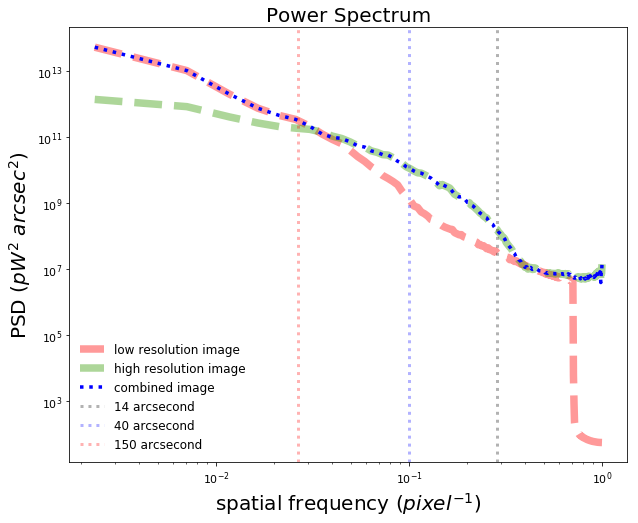

In [4]:
from combine_fuction import combine_2d

combine_2d(
    path+'orion_planck_used.fits',      # filename of the input low resolution FITS image
    path+'orion_scuba2_850_cutad.fits', # filename of the input high resolution FITS image
    path+'combined_step.fits',          # filename of the output combined image
    lowresfwhm = 100.,                  # Angular resolution of the low resolution image, used as angular scale of the step threshold for step kernel
    pixscale = 4.,                      # The pixel size in the input high resolution image, in unit arcsec
    angular_scales = angular_scales,    # angular scales plot in vline
    #kernel = kernel_option
    kernel = 'step',                    # setup function. Options: step/feather/immerge/butterworth/.....
    #kernel = 'feather',
    #kernel = 'immerge',
    verbose=True,                       # power spectrum check
    generatefig=True,
   )


Show SCUBA2 map and combined SCUBA2 map

/Users/shjiao/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/aplpy/labels.py:432: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if self.coord == x or self.axis.apl_tick_positions_world[ipos] > 0:


INFO: Auto-setting vmin to -1.859e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.218e+03 [aplpy.core]
INFO: Auto-setting vmin to -1.587e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.608e+03 [aplpy.core]


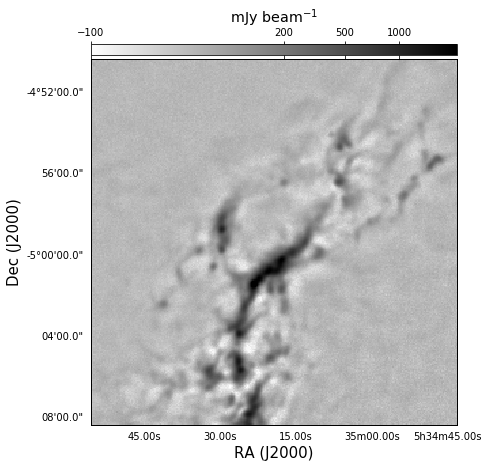

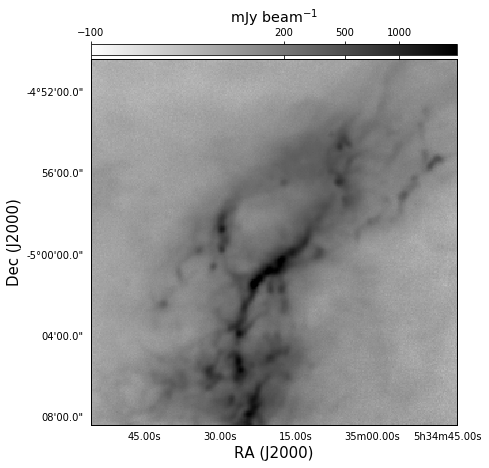

In [5]:
f = aplpy.FITSFigure(path+'orion_scuba2_850_cutad.fits', figsize=(7.,7.))
f.show_colorscale(cmap='gist_yarg')

f.add_colorbar()
f.colorbar.show()

f.recenter(83.83072382,-4.99,width=0.3,height=0.3)


f.tick_labels.set_font(size='xx-large')
f.axis_labels.set_font(size='xx-large')
f.colorbar.set_location('top')
f.colorbar.set_axis_label_text(r'mJy ${\rm beam}$$^{-1}$')
f.show_colorscale(vmin=-100.,vmax=2000.,cmap='gist_yarg',stretch='arcsinh')
f.colorbar.set_width(0.15)
f.colorbar.set_ticks([-100.0,200.,500.,1000.,])
f.tick_labels.set_font(size=10)
f.colorbar.set_axis_label_font(size='x-large')
f.axis_labels.set_font(size=15)

f = aplpy.FITSFigure(path+'combined_step.fits', figsize=(7.,7.))
f.show_colorscale(cmap='gist_yarg')

f.add_colorbar()
f.colorbar.show()

f.recenter(83.83072382,-4.99,width=0.3,height=0.3)


f.tick_labels.set_font(size='xx-large')
f.axis_labels.set_font(size='xx-large')
f.colorbar.set_location('top')
f.colorbar.set_axis_label_text(r'mJy ${\rm beam}$$^{-1}$')
f.show_colorscale(vmin=-100.,vmax=2000.,cmap='gist_yarg',stretch='arcsinh')
f.colorbar.set_width(0.15)
f.colorbar.set_ticks([-100.0,200.,500.,1000.,])
f.tick_labels.set_font(size=10)
f.colorbar.set_axis_label_font(size='x-large')
f.axis_labels.set_font(size=15)



# Use butterworth kernel to get the combined SCUBA2 image step by step

Read data

In [6]:
hdu_low = fits.open(path+'orion_planck_used.fits')
header_low = hdu_low[0].header
data_low = hdu_low[0].data
data_low = data_low

hdu_high = fits.open(path+'orion_scuba2_850_cutad.fits')
header_high = hdu_high[0].header
data_high = hdu_high[0].data

# give input images the same x and y dimension
data_low_same, header_low_same = same_dimension(data_low,header_low) 
data_high_same, header_high_same = same_dimension(data_high,header_high)

Construct weighting kernals

In [7]:
def butterworth(
                nax2,
                nax1,
                lowresfwhm,
                highresfwhm,
                pixscale,
                data_low_same,
                th_min,
                th_max,
                n,
                ):
    """
        Purpose:
        Construct the weight kernels for the fourier transformed low
        resolution and high resolution 1d arrays.  The kernels are the step fuctions in
        fourier transforms with the step at low-resolution beam and (1-[that kernel])
        Parameters.
        Input:
        x           [int] : Number of pixels
        lowresfwhm  [float] : Angular resolution of the low resolution image (FWHM)
        highresfwhm [float] : Angular resolution of the high resolution image (FWHM)
        pixscale    [float] : The pixel size in the input high resolution image
        th_min      [float] : Min angular scale of the butterworth range
        th_max      [float] : Max angular scale of the butterworth range
        n           [float] : Pole of the buuterworth function
        Output:
        kfft  [float array]: 1d array containing the weighting for the low resolution 1d array
        ikfft [float array]: 1d array containing the weighting for the high resolution 1d array
        """
    ygrid, xgrid = np.indices(data_low_same.shape, dtype='float')
    fwhm = np.sqrt(8*np.log(2))
    sigma_low = lowresfwhm/fwhm/pixscale
    gaussian_low = np.exp(-((xgrid - data_low.shape[1]/2)**2+(ygrid - data_low.shape[0]/2)**2)/(2*sigma_low**2))
    G_low = np.abs(np.fft.fft2(gaussian_low))
    G_low /= G_low.max()
    
    sigma_high = highresfwhm/fwhm/pixscale
    gaussian_high = np.exp(-((xgrid - data_low_same.shape[1]/2)**2+(ygrid - data_low_same.shape[0]/2)**2)/(2*sigma_high**2))
    G_high = np.abs(np.fft.fft2(gaussian_high))
    G_high /= G_high.max()
    
    rr = ((xgrid - data_low_same.shape[1]/2)**2+(ygrid - data_low_same.shape[0]/2)**2)**0.5
    image_scale =  data_low_same.shape[0]/np.sqrt(2)
    ring1 = (rr >= (image_scale*pixscale/th_min))
    kfft1 = np.fft.fftshift(ring1)
    
    ring2 = (rr <= (image_scale*pixscale/th_max))
    kfft2 = np.fft.fftshift(ring2)
    
    #######
    
    step = 1 - kfft1 - kfft2
    rrr=  ((xgrid - data_low.shape[1]/2)**2 + (ygrid - data_low.shape[0]/2)**2)**0.5
    r0 = (image_scale*pixscale/th_min+image_scale*pixscale/th_max)/2.0
    w_step = step* (1-1/(1+(r0/rrr)**(2*n)))
    w_step = w_step / w_step.max()
    w_step = (w_step - w_step.min())/(w_step.max() - w_step.min())
    w_low = kfft2 + w_step
    w_high = 1-w_low
    
    kfft = w_low*G_high/G_low
    ikfft = 1-w_low

    return kfft, ikfft


In [8]:
nax2 = header_high_same['naxis2']
nax1 = header_high_same['naxis1']
lowersfwhm = 40.   #Angular resolution of the low resolution image (FWHM)
highresfwhm = 14.  #Angular resolution of the high resolution image (FWHM)
pixscale = 4.      #The pixel size in the input high resolution image
th_min = 95.       #Min angular scale of the butterworth range
th_max = 140.      #Max angular scale of the butterworth range
n = 5.             #pole of the buuterworth function
kfft, ikfft = butterworth(nax2, nax1, lowersfwhm, highresfwhm, pixscale,data_low_same, th_min, th_max, n)

/Users/shjiao/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in divide


In [9]:
# Combine and inverse fourier transform the images
combo_im = fft2_add(data_low_same,data_high_same,kfft,ikfft)

In [10]:
# output combined image
outpath = path+'combined_butter_omc3.fits'
header = header_high_same
if os.path.exists(outpath):
    os.remove(outpath)
fits.writeto(outpath,combo_im,header=header)

Show combined SCUBA2 map by using butterworth kernel

INFO: Auto-setting vmin to -1.824e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.670e+03 [aplpy.core]


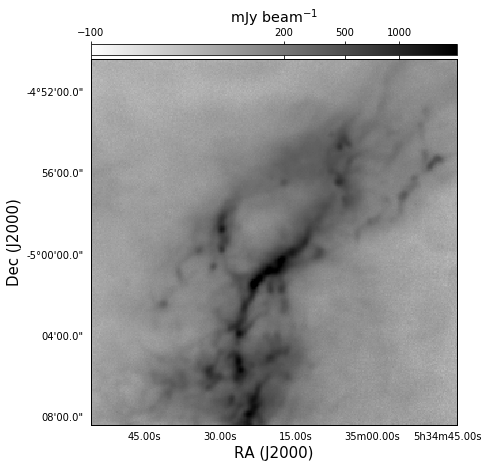

In [12]:
f = aplpy.FITSFigure(path+'combined_butter_omc3.fits', figsize=(7.,7.))
f.show_colorscale(cmap='gist_yarg')

f.add_colorbar()
f.colorbar.show()

f.recenter(83.83072382,-4.99,width=0.3,height=0.3)


f.tick_labels.set_font(size='xx-large')
f.axis_labels.set_font(size='xx-large')
f.colorbar.set_location('top')
f.colorbar.set_axis_label_text(r'mJy ${\rm beam}$$^{-1}$')
f.show_colorscale(vmin=-100.,vmax=2000.,cmap='gist_yarg',stretch='arcsinh')
f.colorbar.set_width(0.15)
f.colorbar.set_ticks([-100.0,200.,500.,1000.,])
f.tick_labels.set_font(size=10)
f.colorbar.set_axis_label_font(size='x-large')
f.axis_labels.set_font(size=15)